# BÀI THỰC HÀNH 2: MẠNG NEURAL TÍCH CHẬP

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses..

Bộ dữ liệu sử dụng: [VinaFood21 dataset](https://arxiv.org/abs/2108.02929).

Link download: https://drive.google.com/file/d/1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR/view?usp=share_link.

In [1]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2025-11-06 13:48:38.982433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762436919.164185      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762436919.226334      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


In [2]:
print("--- KIỂM TRA GPU ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Chỉ định TensorFlow chỉ sử dụng GPU đầu tiên nếu có nhiều cái
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Bật chế độ tăng trưởng bộ nhớ (memory growth) để tránh chiếm hết VRAM
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Đã phát hiện và thiết lập {len(gpus)} GPU:")
        print(gpus)
    except RuntimeError as e:
        # Lỗi xảy ra nếu thiết bị đã được khởi tạo
        print(e)
else:
    print("Không tìm thấy GPU. TensorFlow đang chạy trên CPU.")
print("--------------------")

--- KIỂM TRA GPU ---
Đã phát hiện và thiết lập 2 GPU:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
--------------------


# Bài 3*: Xây dựng mô hình ResNet-18, đánh giá mô hình ResNet-18 trên bộ dữ liệu VinaFood21 sử dụng các độ đo precision, recall, và F1 (Sử dụng Adam làm optimizer).

**ResNet Block**

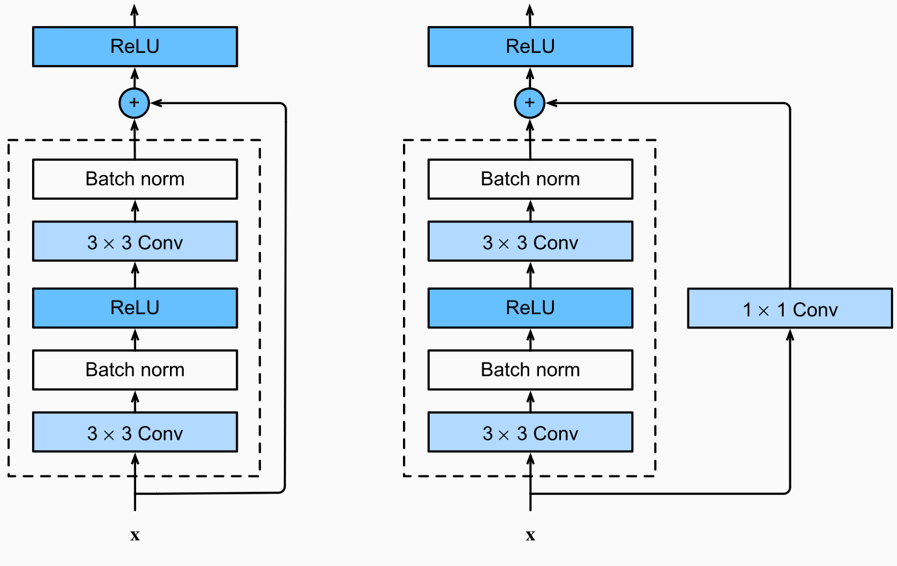

**ResNet**

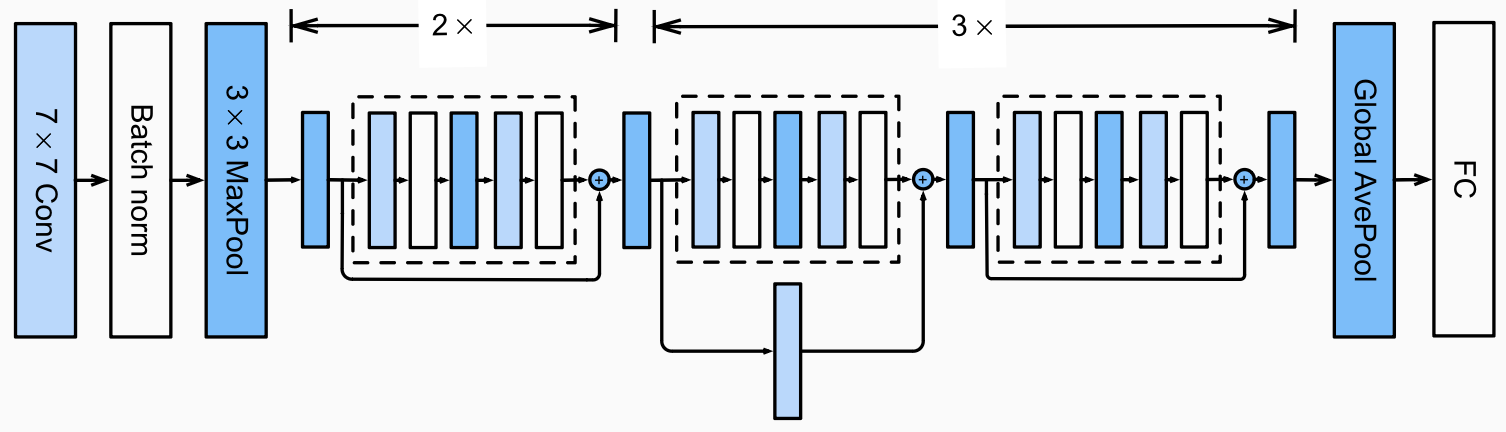

## 1. Define residual_block

In [3]:
from tensorflow.keras.layers import Conv2D, Add, Activation, BatchNormalization
from tensorflow import Tensor

def residual_block(x:Tensor, filters:int, stride=1) -> Tensor:
    """
    Inp:
        x: tensor ảnh đầu vào
        filters: số channels của 2 lớp Conv2D 3x3 - ở kiến trúc Resnet 18 sẽ bằng nhau 
    Out: 
        Tensor cho block tiếp theo
    """

    shortcut = x # lưu lại để add

    x = Conv2D(filters=filters, 
               kernel_size=(3,3), 
               strides=stride, # Chấp nhận dùng strides >1 để giảm kích thước spatical (w, h)
               padding='same')(x) 
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv2D(filters=filters, 
               kernel_size=(3,3), 
               strides=1, # Không giảm kích thước ở đây,vì nếu giảm kích thước sau khi trích xuất đặc trưng ở conv trước thì sẽ gây mất mát nhiều hiệu xuất
               padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters: # Stride != 1 => main branch đã thay đổi spatical, conv 1x1 cũng cần thay đổi theo để có thể cộng
        shortcut = Conv2D(filters=filters, kernel_size=(1,1), strides = stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    out = Add()([x, shortcut])
    out = Activation('relu')(out)

    return out

In [4]:
# Define simple restnet model

from tensorflow.keras.layers import Input, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model

inp = Input(shape=(28, 28, 1))
x = Conv2D(32, (3,3), padding='same', activation='relu')(inp)
x = residual_block(x, 32)
x = residual_block(x, 32)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = residual_block(x, 64, stride=2)
x = residual_block(x, 64)
x = GlobalAveragePooling2D()(x)
out = Dense(units=10, activation='softmax')(x)

sample_resnet_model = Model(inputs=inp, outputs=out)
sample_resnet_model.summary()

I0000 00:00:1762436931.400564      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 28, 28,    │          0 │ add_1[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ activation_3[0][

 Total params: 171,146 (668.54 KB)

 Trainable params: 170,250 (665.04 KB)

 Non-trainable params: 896 (3.50 KB)

## 2. Test On MINIST Dataset

In [5]:
from tensorflow.keras.datasets import mnist

# load data vô Ram
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f"Kích thước tập train {X_train.shape}, kích thước tập test {X_test.shape}")
print(f"kích thước label y_train: {y_train.shape}, y_test: {y_test.shape}")

# Chuẩn hóa (normalize) và reshape
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"Initial dimention of X_train {X_train[1].shape}")

# Ta cần thêm 1 chanel ảo vô hình để input vô model là (28, 28, 1)
# Thêm chiều channel
X_train = np.expand_dims(X_train, axis=-1)  # (60000, 28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)    # (10000, 28, 28, 1)

print(f"X_train - After add a chanel {X_train[1].shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Kích thước tập train (60000, 28, 28), kích thước tập test (10000, 28, 28)
kích thước label y_train: (60000,), y_test: (10000,)
Initial dimention of X_train (28, 28)
X_train - After add a chanel (28, 28, 1)


In [6]:
from tensorflow.keras import utils

# Chuyển labels y_train và y_test sang one-hot
print(f"Initial dimention of y_train {y_train.shape}") # (60000, 1)

num_classes = 10
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

print(f"y_train - After onehot encode {y_train_cat.shape}") # (60000, 10)

Initial dimention of y_train (60000,)
y_train - After onehot encode (60000, 10)


In [7]:
# Chia validation data
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.1, random_state=42)

print(f"X_train mới có kích thước: {X_tr.shape} | X_test có kích thước {X_val.shape}")
print(f"y_tr mới có kích thước: {y_tr.shape} | y_val mới có kích thước {y_val.shape}")

X_train mới có kích thước: (54000, 28, 28, 1) | X_test có kích thước (6000, 28, 28, 1)
y_tr mới có kích thước: (54000, 10) | y_val mới có kích thước (6000, 10)


In [8]:
from tensorflow.keras import optimizers

sample_resnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-4),
    loss='categorical_crossentropy', # y label là (,10) one-hot nên không dùng sparse_categorical_crossentropy
    metrics=['accuracy']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    # Dừng sớm nếu val_loss không giảm
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    
    # Giảm learning rate khi val_loss không cải thiện
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    
    # Lưu model tốt nhất
    ModelCheckpoint(
        'best_vinafood_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [10]:
print("--- Bắt đầu huấn luyện ---")
start_time = time.time()

history = sample_resnet_model.fit(
    X_tr,
    y_tr,
    batch_size=64,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

end_time = time.time()
print(f"--- Hoàn thành huấn luyện trong {end_time - start_time:.2f} giây ---")

--- Bắt đầu huấn luyện ---
Epoch 1/20


I0000 00:00:1762436942.658469      60 service.cc:148] XLA service 0x7d7fc4024530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762436942.659158      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762436943.514673      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 13/844 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2043 - loss: 2.2616

I0000 00:00:1762436947.646872      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


844/844 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8888 - loss: 0.4415 - val_accuracy: 0.9847 - val_loss: 0.0517 - learning_rate: 5.0000e-04
Epoch 2/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9874 - loss: 0.0473 - val_accuracy: 0.9852 - val_loss: 0.0538 - learning_rate: 5.0000e-04
Epoch 3/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9905 - loss: 0.0327 - val_accuracy: 0.9868 - val_loss: 0.0463 - learning_rate: 5.0000e-04
Epoch 4/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9923 - loss: 0.0251 - val_accuracy: 0.9902 - val_loss: 0.0356 - learning_rate: 5.0000e-04
Epoch 5/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9940 - loss: 0.0206 - val_accuracy: 0.9843 - val_loss: 0.0495 - learning_rate: 5.0000e-04
Epoch 6/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9944 - loss: 0.0173 - val_accuracy: 0.9828 - val_loss: 0.0571 - learning_rate: 5.0000e-04
Epoch 7/20
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9

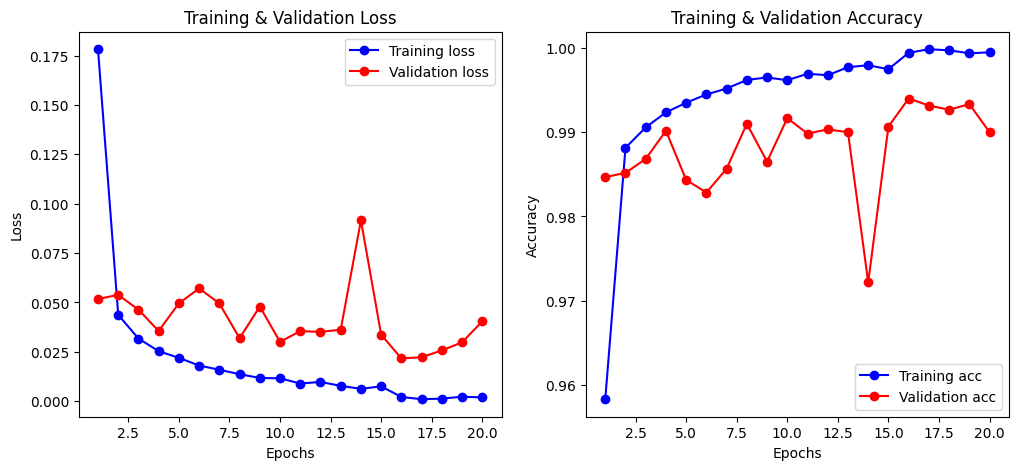

In [11]:
# Lấy dữ liệu từ history
history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Lấy dự đoán trên tập test
y_pred_prob = sample_resnet_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1) # Chuyển từ xác suất (softmax) về nhãn (0-9)

print("\n--- ĐÁNH GIÁ TỔNG THỂ (MACRO AVG) ---")

# Tính toán các độ đo tổng thể
acc = accuracy_score(y_test, y_pred)
pre_macro = precision_score(y_test, y_pred, average='macro')
rec_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro') # Đây là F1-macro bạn yêu cầu

print(f"Overall Accuracy: {acc:.4f}")
print(f"Macro Precision:  {pre_macro:.4f}")
print(f"Macro Recall:     {rec_macro:.4f}")
print(f"Macro F1-Score:   {f1_macro:.4f}")

print("\n--- ĐÁNH GIÁ CHI TIẾT TỪNG CHỮ SỐ (0-9) ---")

# Sử dụng classification_report để in chi tiết precision, recall, f1-score cho từng lớp
# 'support' là số lượng mẫu thực tế của từng lớp trong tập test
print(classification_report(y_test, y_pred, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

--- ĐÁNH GIÁ TỔNG THỂ (MACRO AVG) ---
Overall Accuracy: 0.9956
Macro Precision:  0.9956
Macro Recall:     0.9955
Macro F1-Score:   0.9956

--- ĐÁNH GIÁ CHI TIẾT TỪNG CHỮ SỐ (0-9) ---
              precision    recall  f1-score   support

           0     0.9969    0.9990    0.9980       980
           1     0.9974    0.9974    0.9974      1135
           2     0.9932    0.9981    0.9957      1032
           3     0.9921    0.9980    0.9951      1010
           4     0.9949    0.9919    0.9934       982
           5     0.9977    0.9933    0.9955       892
           6     0.9990    0.9937    0.9963       958
           7     0.9961    0.9961    0.9961      1028
           8     0.9979    0.9949    0.9964       974
           9     0.9911    0.9931    0.9921      1009

    accuracy                         0.9956     10000
   macro avg     0.9956    0.9955    0.9956     10000
weighted avg     0.9956    0.9956    0.9956     10000



## 3. Test On Vina Foods Dataset

In [13]:
train_dir = '/kaggle/input/vinafoodds201/VinaFood21/train'
test_dir = '/kaggle/input/vinafoodds201/VinaFood21/test'

BATCH_SIZE = 32

# Tạo train dataset
# image_dataset_from_directory -> tf.data.Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='int'  # Cho sparse_categorical_crossentropy
)

# Mỗi batch là (images_tensor, labels_tensor)
for images, labels in train_ds.take(1): # .take(1) => Lấy batch đầu tiên, ta set batch_size = 32 thì lấy 32 ảnh
    print(f"Batch_shape = {images.shape}") # 32, 224, 224, 3 - 32 là batch_size - số ảnh, 224, 224, 3 là kích thước ảnh
    print(f"Labels shape = {labels.shape}") # (32, ) có 32 labels của 32 ảnh

Found 10043 files belonging to 21 classes.
Using 8035 files for training.
Batch_shape = (32, 224, 224, 3)
Labels shape = (32,)


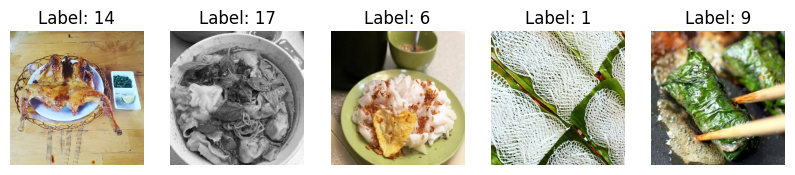

In [14]:
import matplotlib.pyplot as plt

# In ra vài ảnh và label tương ứng của tập train
for images, labels in train_ds.take(1):
    # Hiển thị 5 ảnh đầu tiên
    plt.figure(figsize=(10, 10))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(tf.cast(images[i], tf.uint8))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [15]:
import pandas as pd
import os

class_names = sorted(os.listdir(train_dir))

mapping_df = pd.DataFrame({
    "Label": list(range(len(class_names))),
    "Class Name": class_names
})
print(f"Có tất cả {len(class_names)} nhãn!")
print(mapping_df)

Có tất cả 21 nhãn!
    Label        Class Name
0       0          banh-can
1       1          banh-hoi
2       2      banh-mi-chao
3       3          banh-tet
4       4   banh-trang-tron
5       5            banh-u
6       6          banh-uot
7       7         bap-nuong
8       8            bo-kho
9       9         bo-la-lot
10     10         bot-chien
11     11             ca-ri
12     12      canh-kho-qua
13     13     canh-khoai-mo
14     14          ga-nuong
15     15            goi-ga
16     16            ha-cao
17     17  hoanh-thanh-nuoc
18     18           pha-lau
19     19            tau-hu
20     20    thit-kho-trung


In [16]:
# tương tự cho val và test subset
# Tạo validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Tạo test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

Found 10043 files belonging to 21 classes.
Using 2008 files for validation.
Found 6681 files belonging to 21 classes.


In [17]:
# Data augmentation layer 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # lật
    tf.keras.layers.RandomRotation(0.1), # xoay không quá 10%
    tf.keras.layers.RandomZoom(0.2), # zoom
])

# Preprocessing function
def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image, training=True)
    return image, label
    
# không augmentation tập val/test
def preprocess_test(image, label):
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

In [18]:
AUTOTUNE = tf.data.AUTOTUNE # Tự động cấu hình TensorFlow nên dùng bao nhiêu CPU để xử lý song song

# Apply preprocessing và optimization
train_ds = (train_ds
    # Áp dụng hàm tiền xử lý preprocess_train ở trên | num_parallel_calls=AUTOTUNE xử lý nhiều batch một lúc → nhanh hơn
    .map(preprocess_train, num_parallel_calls=AUTOTUNE) 
    .cache()  # Cache vào RAM để mỗi lần load nhanh hơn, không cần load từ ổ cứng
    .prefetch(buffer_size=AUTOTUNE)  # Khi GPU đang train batch hiện tại => CPU đã chuẩn bị sẵn batch tiếp theo
)

val_ds = (val_ds
    .map(preprocess_test, num_parallel_calls=AUTOTUNE) # Không áp dụng agumentarion (lật, xoay, zoom) trên val/test
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

test_ds = (test_ds
    .map(preprocess_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## 4. Define Resnet model

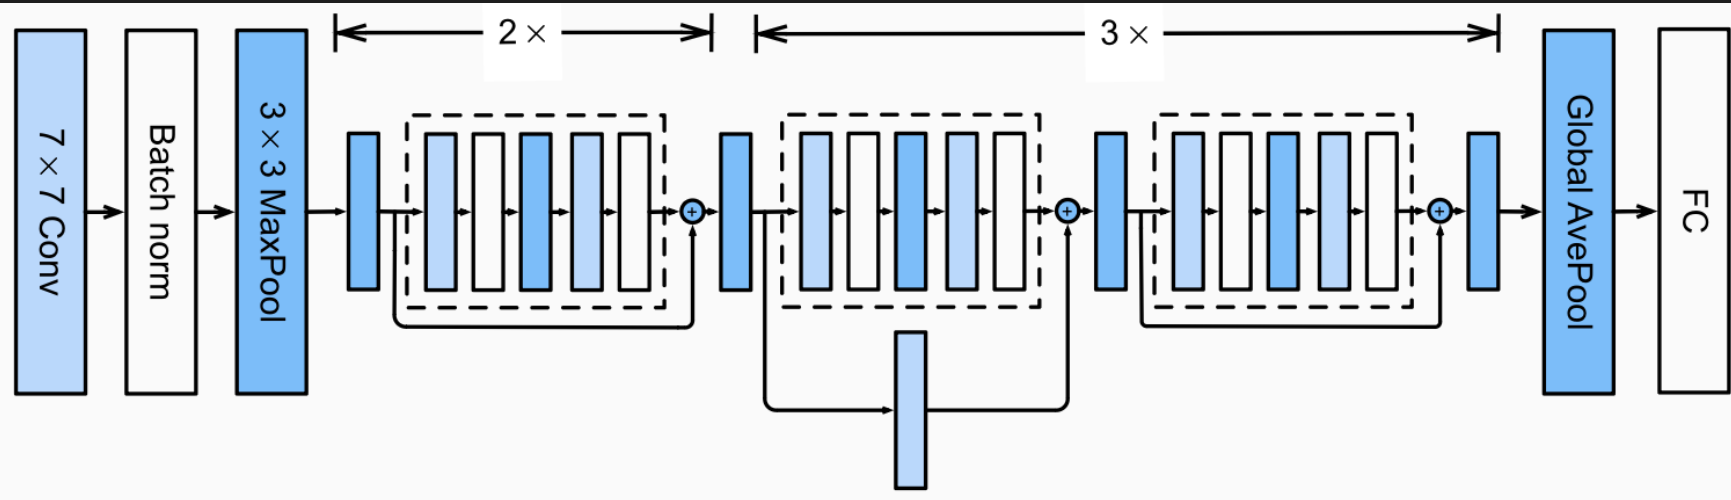

In [19]:
inp = Input(shape=(224, 224, 3))

# 1. Stem 
x = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')(inp)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# 2. Conv2_x (2 blocks, 64 filters)
# Không có Activation('relu') bên ngoài vì residual_block đã có sẵn
x = residual_block(x, filters=64, stride=1) # Stride = 1 vì MaxPool đã giảm kích thước rồi
x = residual_block(x, filters=64, stride=1)

# 3. conv3_x (2 blocks, 128 filters)
x = residual_block(x, filters=128, stride=2) # Stride = 2 để giảm kích thước (56x56 -> 28x28)
x = residual_block(x, filters=128, stride=1)

# 4. conv4_x (2 blocks, 256 filters)
x = residual_block(x, filters=256, stride=2) # Stride = 2 để giảm kích thước (28x28 -> 14x14)
x = residual_block(x, filters=256, stride=1)

# 5. conv5_x (2 blocks, 512 filters)
x = residual_block(x, filters=512, stride=2) # Stride = 2 để giảm kích thước (14x14 -> 7x7)
x = residual_block(x, filters=512, stride=1)

# --- 6. Head ---
x = GlobalAveragePooling2D()(x)
out = Dense(units=21, activation='softmax')(x) # units=21 cho 21 nhãn VinaFood

resnet_model = Model(inputs=inp, outputs=out)

# In cấu trúc model
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_8[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_9[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 56, 56,    │          0 │ add_4[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_10[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_11[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_14[0][0] 

 Total params: 11,201,685 (42.73 MB)

 Trainable params: 11,192,085 (42.69 MB)

 Non-trainable params: 9,600 (37.50 KB)

## 5. Compile and Fit resnet model 

In [20]:
# COMPILE MODEL
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0, weight_decay=1e-5)

resnet_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    # Dừng sớm nếu val_loss không giảm
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    
    # Giảm learning rate khi val_loss không cải thiện
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    
    # Lưu model tốt nhất
    ModelCheckpoint(
        'best_vinafood_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 113s 327ms/step - accuracy: 0.2088 - loss: 2.6969 - val_accuracy: 0.0792 - val_loss: 5.2350 - learning_rate: 1.0000e-04
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.3841 - loss: 2.0145 - val_accuracy: 0.1763 - val_loss: 4.3354 - learning_rate: 1.0000e-04
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 33s 129ms/step - accuracy: 0.5728 - loss: 1.4346 - val_accuracy: 0.0986 - val_loss: 10.3090 - learning_rate: 1.0000e-04
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 32s 128ms/step - accuracy: 0.7661 - loss: 0.8186 - val_accuracy: 0.1200 - val_loss: 12.1649 - learning_rate: 1.0000e-04
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 33s 130ms/step - accuracy: 0.8473 - loss: 0.5108 - val_accuracy: 0.1419 - val_loss: 11.9059 - learning_rate: 1.0000e-04
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.9220 - loss: 0.2744 - val_accuracy: 0.1892 - val_loss: 5.6450 - learning_rate: 1.0000e-04
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 33

In [22]:
test_dir = "/kaggle/input/vinafoodds201/VinaFood21/test"

bad_files = []

for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        if img_file.startswith('.'):
            continue
        
        img_path = os.path.join(class_path, img_file)
        try:
            file_bytes = tf.io.read_file(img_path)
            img = tf.image.decode_image(file_bytes, channels=3)
            if img.shape[0] == 0 or img.shape[1] == 0:
                raise Exception("0-byte image")
        except:
            bad_files.append(img_path)

print("Ảnh lỗi:", bad_files)

Ảnh lỗi: []


In [23]:
import glob

# Lấy danh sách class_names từ train_dir hoặc test_dir đều được
train_dir = "/kaggle/input/vinafoodds201/VinaFood21/test"
class_names = sorted(os.listdir(train_dir))

# Map tên class -> index
class_to_index = {name: i for i, name in enumerate(class_names)}

test_paths = []
test_labels = []

for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_path in glob.glob(os.path.join(class_path, "*.jpg")):
            if img_path not in bad_files:
                test_paths.append(img_path)
                test_labels.append(class_to_index[class_name])

In [24]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img, label

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

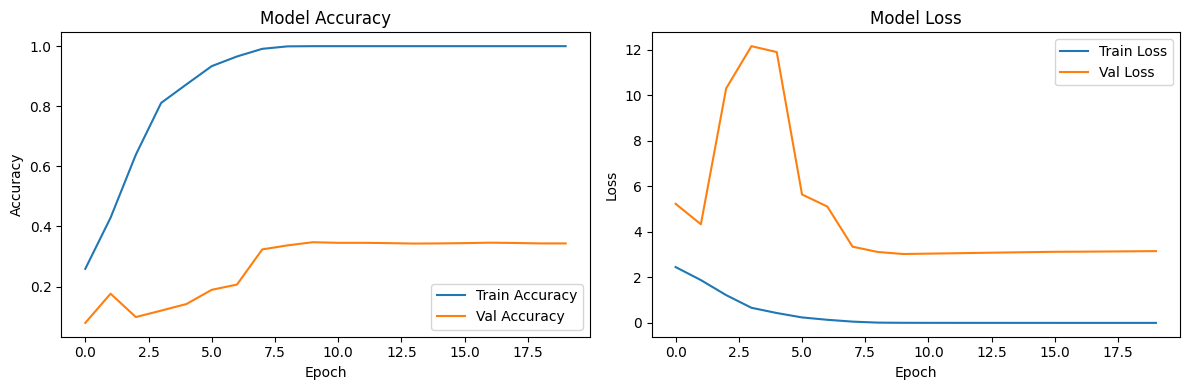

In [25]:
# VISUALIZE TRAINING
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

>Model bị overfiting rất rất nặng :((

In [26]:
# EVALUATE 
test_loss, test_accuracy = resnet_model.evaluate(test_ds)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

209/209 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.2515 - loss: 3.6616

Test Loss: 3.4472
Test Accuracy: 0.2947


In [27]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98m

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

        banh-can       0.18      0.11      0.14       241
        banh-hoi       0.35      0.30      0.32       607
    banh-mi-chao       0.30      0.17      0.22       289
        banh-tet       0.41      0.18      0.25       364
 banh-trang-tron       0.14      0.15      0.14       309
          banh-u       0.19      0.10      0.13       176
        banh-uot       0.25      0.23      0.24       560
       bap-nuong       0.16      0.17      0.16       143
          bo-kho       0.29      0.34      0.31       338
       bo-la-lot       0.30      0.80      0.44       458
       bot-chien       0.20      0.16      0.18       276
           ca-ri       0.27      0.12      0.17       171
    canh-kho-qua       0.55      0.48      0.51       290
   canh-khoai-mo       0.57      0.71      0.63       197
        ga-nuong       0.19      0.28      0.23       372
          goi-ga       0.21      0.33      0.26       290
          ha-

In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.3019
Recall:    0.2947
F1-score:  0.2799


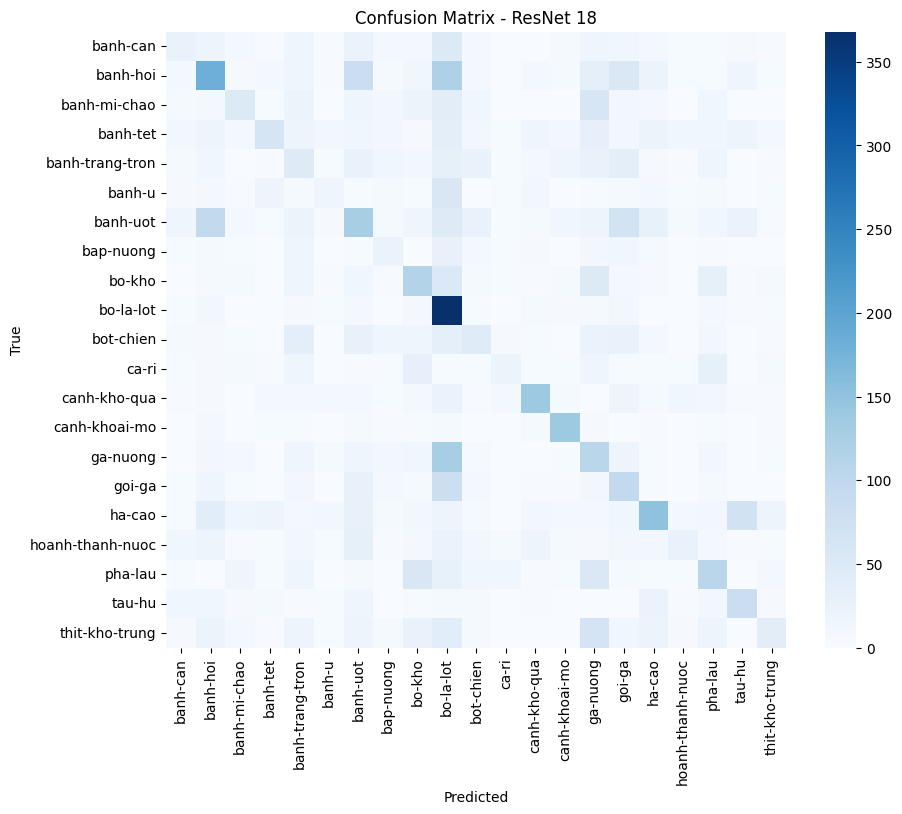

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet 18")
plt.show()

## 6. Cải thiện mô hình

### Weight Initialization + Drop out 

In [31]:

import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Add, Activation, BatchNormalization, 
    Input, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.models import Model
from tensorflow import Tensor
import numpy as np

In [32]:
def residual_block(x: Tensor, filters: int, stride=1, use_dropout=False) -> Tensor:
    """
    - Thêm kernel_initializer='he_uniform' Kaiming init cho ReLU | Mặc định là 'Glorot uniform' - KHÔNG PHẢI CHO RELU!
    - Thêm bias=False cho Conv2D
    - Thêm optional Dropout
    """
    shortcut = x
    
    # Main path - Conv 1
    x = Conv2D(
        filters=filters, 
        kernel_size=(3, 3), 
        strides=stride,
        padding='same',
        use_bias=False, # Không dùng bias khi có BatchNorm
        kernel_initializer='he_uniform' # THÊM: Kaiming initialization
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if use_dropout: # THÊM: Optional Dropout sau Conv đầu tiên
        x = Dropout(0.2)(x)
    
    # Main path - Conv 2
    x = Conv2D(
        filters=filters,
        kernel_size=(3, 3),
        strides=1,
        padding='same',
        use_bias=False,
        kernel_initializer='he_uniform'
    )(x)
    x = BatchNormalization()(x)
    
    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(
            filters=filters,
            kernel_size=(1, 1),
            strides=stride,
            padding='same',
            use_bias=False,
            kernel_initializer='he_uniform'
        )(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    out = Add()([x, shortcut])
    out = Activation('relu')(out)
    return out

### IMPROVED DATA AUGMENTATION

In [33]:
def get_strong_augmentation():
    """
    Augmentation mạnh hơn trước
    """
    return tf.keras.Sequential([
        # Random flip
        tf.keras.layers.RandomFlip("horizontal"),
        
        # Random rotation (±15 độ thay vì ±10%)
        tf.keras.layers.RandomRotation(0.042),  # 15/360 = 0.042
        
        # THÊM: RandomZoom với scale lớn hơn
        tf.keras.layers.RandomZoom(
            height_factor=(-0.2, 0.2),  # Zoom in/out 20%
            width_factor=(-0.2, 0.2)
        ),
        
        # THÊM: RandomTranslation (shift ảnh)
        tf.keras.layers.RandomTranslation(
            height_factor=0.1,
            width_factor=0.1
        ),
        
        # THÊM: RandomContrast
        tf.keras.layers.RandomContrast(factor=0.2),
        
        # THÊM: RandomBrightness
        tf.keras.layers.RandomBrightness(factor=0.2),
    ], name='strong_augmentation')

### PROPER NORMALIZATION

In [34]:
def preprocess_train(image, label):
    """
    CẢI TIẾN: Normalize theo ImageNet statistics
    """
    # Cast to float32
    image = tf.cast(image, tf.float32) / 255.0
    
    # ✅ THÊM: Normalize theo ImageNet mean/std
    mean = tf.constant([0.485, 0.456, 0.406])
    std = tf.constant([0.229, 0.224, 0.225])
    image = (image - mean) / std
    
    return image, label


def preprocess_test(image, label):
    """Preprocessing cho validation/test"""
    image = tf.cast(image, tf.float32) / 255.0
    
    # THÊM: Normalize theo ImageNet mean/std
    mean = tf.constant([0.485, 0.456, 0.406])
    std = tf.constant([0.229, 0.224, 0.225])
    image = (image - mean) / std
    
    return image, label

### LOAD DATASET

In [35]:
def load_dataset(train_dir, test_dir, batch_size=32):
    """
    CẢI TIẾN: Thêm augmentation vào pipeline
    """
    # Train dataset
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(224, 224),
        batch_size=batch_size,
        label_mode='int'
    )
    
    # Validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(224, 224),
        batch_size=batch_size,
        label_mode='int'
    )
    
    # Test dataset
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(224, 224),
        batch_size=batch_size,
        label_mode='int',
        shuffle=False
    )
    
    # CẢI TIẾN: Apply augmentation + preprocessing
    AUTOTUNE = tf.data.AUTOTUNE
    augmentation = get_strong_augmentation()
    
    # Train pipeline
    train_ds = (train_ds
        .map(preprocess_train, num_parallel_calls=AUTOTUNE)
        .map(lambda x, y: (augmentation(x, training=True), y), 
             num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    # Val/Test pipeline
    val_ds = (val_ds
        .map(preprocess_test, num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    test_ds = (test_ds
        .map(preprocess_test, num_parallel_calls=AUTOTUNE)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return train_ds, val_ds, test_ds

### BUILD MODEL 

In [36]:
def build_resnet18(num_classes=21, use_dropout=False):
    """
    CẢI TIẾN:
    - Thêm kernel_initializer cho tất cả layers
    - Thêm optional Dropout
    - Thêm Dropout trước output layer
    """
    inp = Input(shape=(224, 224, 3))
    
    # --- Stem ---
    x = Conv2D(
        filters=64,
        kernel_size=(7, 7),
        strides=2,
        padding='same',
        use_bias=False, 
        kernel_initializer='he_uniform' 
    )(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
    
    # --- Conv2_x (2 blocks, 64 filters) ---
    x = residual_block(x, filters=64, stride=1, use_dropout=use_dropout)
    x = residual_block(x, filters=64, stride=1, use_dropout=use_dropout)
    
    # --- Conv3_x (2 blocks, 128 filters) ---
    x = residual_block(x, filters=128, stride=2, use_dropout=use_dropout)
    x = residual_block(x, filters=128, stride=1, use_dropout=use_dropout)
    
    # --- Conv4_x (2 blocks, 256 filters) ---
    x = residual_block(x, filters=256, stride=2, use_dropout=use_dropout)
    x = residual_block(x, filters=256, stride=1, use_dropout=use_dropout)
    
    # --- Conv5_x (2 blocks, 512 filters) ---
    x = residual_block(x, filters=512, stride=2, use_dropout=use_dropout)
    x = residual_block(x, filters=512, stride=1, use_dropout=use_dropout)
    
    # --- Head ---
    x = GlobalAveragePooling2D()(x)
    
    # THÊM: Dropout trước output layer (quan trọng!)
    if use_dropout:
        x = Dropout(0.5)(x)
    
    out = Dense(
        units=num_classes,
        activation='softmax',
        kernel_initializer='glorot_uniform'  # ✅ THÊM: Xavier init
    )(x)
    
    model = Model(inputs=inp, outputs=out, name='ResNet18')
    return model

### TRAINING CONFIGURATION 

In [37]:
def get_callbacks(checkpoint_path='best_model.keras'):
    """
    ✅ CẢI TIẾN: Callbacks tốt hơn
    """
    return [
        # Early Stopping - patience tăng lên
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,  # ✅ Tăng từ 10 → 15
            restore_best_weights=True,
            verbose=1
        ),
        
        # ReduceLROnPlateau - aggressive hơn
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        
        # ModelCheckpoint - lưu best model
        tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        
        # ✅ THÊM: Learning rate scheduler (StepLR-style)
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch, lr: lr * 0.1 if epoch % 30 == 0 and epoch > 0 else lr,
            verbose=1
        )
    ]

### VISUALIZATION FUNCTIONS

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history):
    """
    ✅ Vẽ biểu đồ Training/Validation Loss và Accuracy
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # === Plot 1: Loss ===
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2, color='#2E86AB')
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#A23B72')
    axes[0].set_title('Model Loss', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=11, loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # === Plot 2: Accuracy ===
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, color='#2E86AB')
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#A23B72')
    axes[1].set_title('Model Accuracy', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].legend(fontsize=11, loc='lower right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("\n✅ Training history plot saved as 'training_history.png'")
    plt.show()


def evaluate_test_metrics(model, test_ds, class_names=None):
    """
    ✅ Đánh giá chi tiết trên test set: Accuracy, Precision, Recall, F1-Score
    
    Args:
        model: Trained model
        test_ds: Test dataset
        class_names: List tên các class (optional)
    """
    print("\n" + "="*60)
    print("📊 DETAILED TEST SET EVALUATION")
    print("="*60)
    
    # 1. Predict on test set
    print("\n🔮 Making predictions on test set...")
    y_true = []
    y_pred = []
    
    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 2. Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # 3. Print overall metrics
    print("\n" + "="*60)
    print("📈 OVERALL METRICS")
    print("="*60)
    print(f"✅ Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"✅ Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"✅ Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"✅ F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
    
    # 4. Print classification report (per-class metrics)
    print("\n" + "="*60)
    print("📊 PER-CLASS METRICS")
    print("="*60)
    
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(np.unique(y_true)))]
    
    report = classification_report(
        y_true, y_pred, 
        target_names=class_names,
        digits=4,
        zero_division=0
    )
    print(report)
    
    # 5. Plot confusion matrix
    print("\n🎨 Generating confusion matrix...")
    plot_confusion_matrix(y_true, y_pred, class_names)
    
    # 6. Return metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'y_true': y_true,
        'y_pred': y_pred
    }
    
    return metrics


def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    ✅ Vẽ confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentage
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot heatmap
    sns.heatmap(
        cm_percent, 
        annot=True, 
        fmt='.1f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Percentage (%)'},
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title('Confusion Matrix (%)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("✅ Confusion matrix saved as 'confusion_matrix.png'")
    plt.show()

### MAIN TRAINING FUNCTION

In [39]:
def train_model(train_dir, test_dir, epochs=50, batch_size=32, 
                initial_lr=1e-4, use_dropout=True):
    """
    Hàm training hoàn chỉnh với visualization và detailed metrics
    
    Args:
        train_dir: Đường dẫn thư mục train
        test_dir: Đường dẫn thư mục test
        epochs: Số epochs (tăng lên 50)
        batch_size: Batch size
        initial_lr: Learning rate ban đầu
        use_dropout: Có dùng dropout không
    
    Returns:
        model: Trained model
        history: Training history
        test_metrics: Dictionary chứa test metrics
    """
    print("=" * 60)
    print("🚀 TRAINING RESNET18 - FIXED VERSION")
    print("=" * 60)
    
    # 1. Load datasets
    print("\n📁 Loading datasets...")
    train_ds, val_ds, test_ds = load_dataset(
        train_dir, test_dir, batch_size=batch_size
    )
    
    # Get class names from train_dir
    class_names = sorted([d for d in tf.io.gfile.listdir(train_dir) 
                         if tf.io.gfile.isdir(tf.io.gfile.join(train_dir, d))])
    print(f"✅ Found {len(class_names)} classes: {class_names[:5]}...")
    
    # 2. Build model
    print("\n🏗️ Building model...")
    model = build_resnet18(num_classes=len(class_names), use_dropout=use_dropout)
    
    # 3. Compile model
    print("\n⚙️ Compiling model...")
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=initial_lr,
        weight_decay=1e-5,  # L2 regularization
        clipvalue=1.0  # Gradient clipping
    )
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 4. Print model summary
    model.summary()
    
    # 5. Get callbacks
    callbacks = get_callbacks('best_vinafood_model.keras')
    
    # 6. Train
    print("\n🏋️ Training started...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    
    # 7. Plot training history
    print("\n📊 Plotting training history...")
    plot_training_history(history)
    
    # 8. Evaluate on test set with detailed metrics
    print("\n📊 Evaluating on test set...")
    test_metrics = evaluate_test_metrics(model, test_ds, class_names)
    
    # 9. Print final summary
    print("\n" + "="*60)
    print("✅ TRAINING COMPLETED SUCCESSFULLY!")
    print("="*60)
    print(f"📈 Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"📈 Final Val Accuracy:   {history.history['val_accuracy'][-1]:.4f}")
    print(f"📈 Test Accuracy:        {test_metrics['accuracy']:.4f}")
    print(f"📈 Test F1-Score:        {test_metrics['f1_score']:.4f}")
    print("="*60)
    
    return model, history, test_metrics

🚀 TRAINING RESNET18 - FIXED VERSION

📁 Loading datasets...
Found 10043 files belonging to 21 classes.
Using 8035 files for training.
Found 10043 files belonging to 21 classes.
Using 2008 files for validation.
Found 6681 files belonging to 21 classes.
✅ Found 21 classes: ['banh-can', 'banh-hoi', 'banh-mi-chao', 'banh-tet', 'banh-trang-tron']...

🏗️ Building model...

⚙️ Compiling model...


Model: "ResNet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 112, 112,  │      9,408 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 56, 56,    │          0 │ activation_25[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 56, 56,    │     36,864 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 56, 56,    │          0 │ activation_26[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 56, 56,    │     36,864 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 56, 56,    │          0 │ add_12[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 56, 56,    │     36,864 │ activation_27[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ activation_28[0]

 Total params: 11,196,885 (42.71 MB)

 Trainable params: 11,187,285 (42.68 MB)

 Non-trainable params: 9,600 (37.50 KB)


🏋️ Training started...

Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.0611 - loss: 3.6939
Epoch 1: val_accuracy improved from -inf to 0.08516, saving model to best_vinafood_model.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 129s 393ms/step - accuracy: 0.0611 - loss: 3.6932 - val_accuracy: 0.0852 - val_loss: 2.9962 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0680 - loss: 3.2320
Epoch 2: val_accuracy did not improve from 0.08516
252/252 ━━━━━━━━━━━━━━━━━━━━ 62s 128ms/step - accuracy: 0.0680 - loss: 3.2318 - val_accuracy: 0.0842 - val_loss: 2.9776 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/50
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.0756 - loss: 3.1157
Epoch 3: val_accuracy did not

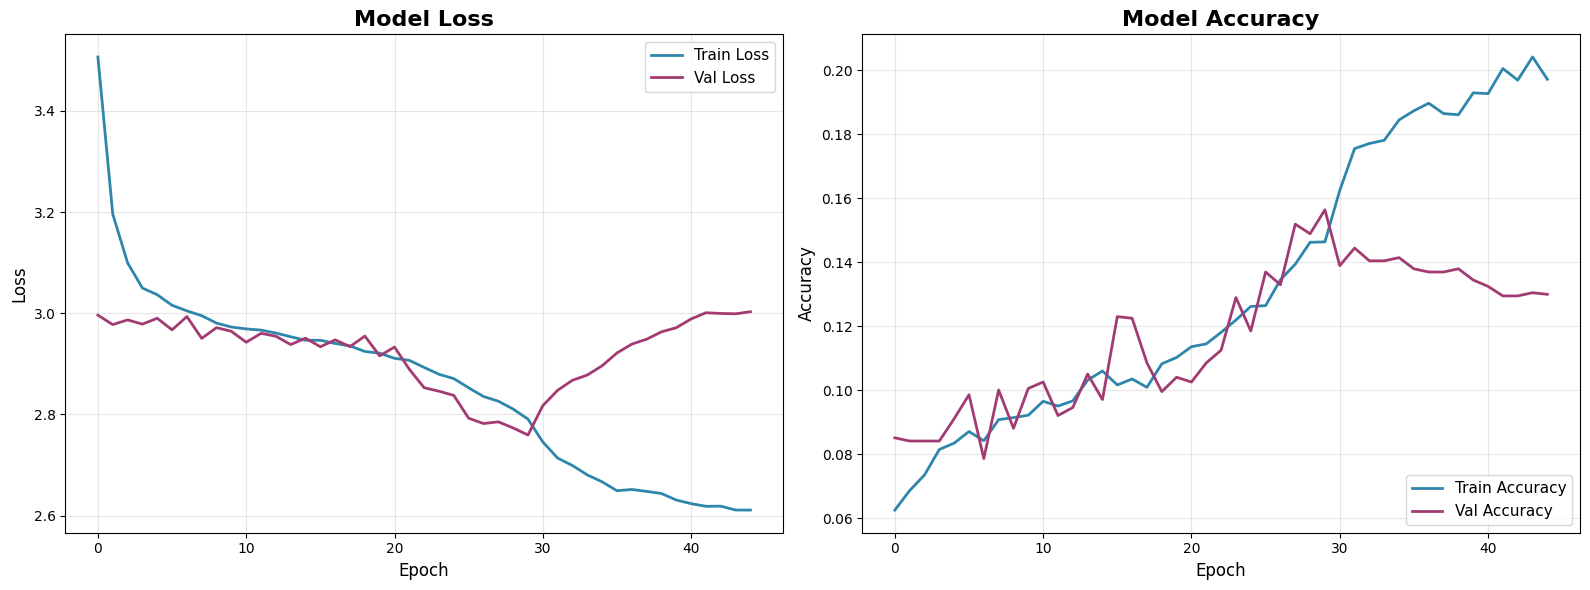


📊 Evaluating on test set...

📊 DETAILED TEST SET EVALUATION

🔮 Making predictions on test set...

📈 OVERALL METRICS
✅ Accuracy:  0.1536 (15.36%)
✅ Precision: 0.1402 (14.02%)
✅ Recall:    0.1536 (15.36%)
✅ F1-Score:  0.1170 (11.70%)

📊 PER-CLASS METRICS
                  precision    recall  f1-score   support

        banh-can     0.1087    0.0207    0.0348       241
        banh-hoi     0.1303    0.0659    0.0875       607
    banh-mi-chao     0.0000    0.0000    0.0000       289
        banh-tet     0.0627    0.0467    0.0535       364
 banh-trang-tron     0.1312    0.2492    0.1719       309
          banh-u     0.0000    0.0000    0.0000       176
        banh-uot     0.1342    0.5857    0.2184       560
       bap-nuong     0.0000    0.0000    0.0000       143
          bo-kho     0.1228    0.4112    0.1891       338
       bo-la-lot     0.1852    0.0109    0.0206       458
       bot-chien     0.0000    0.0000    0.0000       276
           ca-ri     0.0000    0.0000    0.0000  

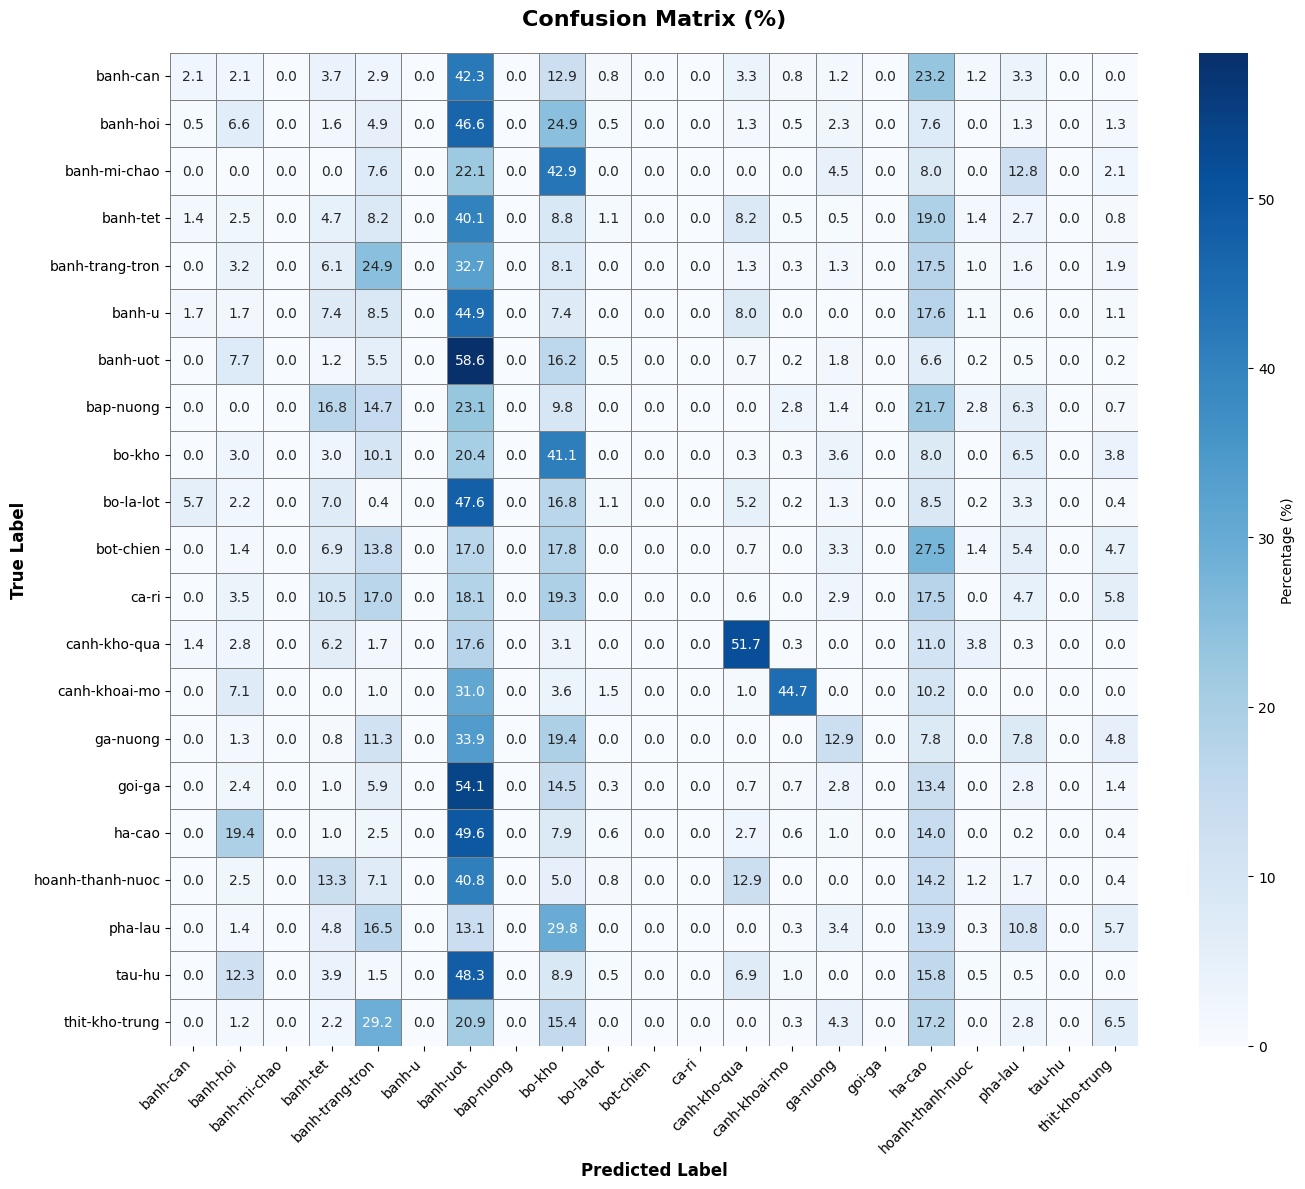


✅ TRAINING COMPLETED SUCCESSFULLY!
📈 Final Train Accuracy: 0.1971
📈 Final Val Accuracy:   0.1300
📈 Test Accuracy:        0.1536
📈 Test F1-Score:        0.1170

✅ Test metrics saved to 'test_metrics.json'


In [40]:
# Đường dẫn datasets
train_dir = '/kaggle/input/vinafoodds201/VinaFood21/train'
test_dir = '/kaggle/input/vinafoodds201/VinaFood21/test'

# Train model
model, history, test_metrics = train_model(
    train_dir=train_dir,
    test_dir=test_dir,
    epochs=50,  # Tăng lên 50 epochs
    batch_size=32,
    initial_lr=1e-4,
    use_dropout=True  # Bật Dropout
)

# Optional: Save final metrics to file
import json
with open('test_metrics.json', 'w') as f:
    json.dump({
        'accuracy': float(test_metrics['accuracy']),
        'precision': float(test_metrics['precision']),
        'recall': float(test_metrics['recall']),
        'f1_score': float(test_metrics['f1_score'])
    }, f, indent=4)
print("\n✅ Test metrics saved to 'test_metrics.json'")

> Tối ưu xong model có hiệu xuất giảm đi 10% 🥹🤫😀😀😀😀😀